In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Othercomputers/Il mio laptop/Machine-Learning-Optimization_new - Copia

In [92]:
#@title Import and utilities 

from Frank_Wolfe.utils.utils import *
from Frank_Wolfe.DFW import *
from Frank_Wolfe.architectures import *
from Frank_Wolfe.MultiClassHingeLoss import *
!pip install barbar
from barbar import Bar
import os
import pickle
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

device = "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
save_stats = True
save_figs = True
load = False

In [94]:
#@title Choose dataset name and architecture of the network 

dataset_name = 'CIFAR100' #@param ['CIFAR10', 'CIFAR100']
model_type = 'WideResNet' #@param ['DenseNet', 'WideResNet', 'GoogLeNet', 'ResNeXt']
if model_type == 'GoogLeNet':
    model = GoogleNet(num_class=10 if dataset_name == 'CIFAR10' else 100)
elif model_type == 'DenseNet':
    model = torchvision.models.densenet121(pretrained=False)
elif model_type == 'ResNeXt':
    model = torchvision.models.resnet101(pretrained=False)
elif model_type == 'WideResNet':
    model =  WideResNet(num_classes=10 if dataset_name == 'CIFAR10' else 100)
else:
    raise ValueError("Please, select an available architecture")

datasetDict = setDatasetAttributes(dataset_name)
trainTransformDict, testTransformDict = setTrainAndTest(dataset_name)

root = f"{dataset_name}-dataset"

trainData = datasetDict['datasetDict'](root=root, train=True, download=True,
                                            transform=trainTransformDict[dataset_name])
testData = datasetDict['datasetDict'](root=root, train=False,
                                        transform=testTransformDict[dataset_name])

loss_criterion = MultiClassHingeLoss().to(device="cuda:0")

Files already downloaded and verified


In [150]:
#@title Choose optimizer and parameters 

optimizer_name = "DFW" #@param  ['DFW', 'Adam', 'AdaGrad', 'SGD with momentum', 'SGD']
momentum = 0.9 #@param {type:"number"}
lr = 0.001 #@param {type:"number"}
eta =  0.1#@param {type:"number"}
beta_1 = 0.9 #@param {type:"number"}
beta_2 = 0.999 #@param {type:"number"}
weight_decay = 0.00 #@param {type:"number"}
multi_prox_step = True #@param {type: "boolean"}
asymptotic_prox_steps_num = 4

if optimizer_name == "DFW":
  optimizer = DFW(params=model.parameters(), eta=eta, momentum=momentum, 
                  prox_steps=1)
  assert eta > 0
elif optimizer_name == "SGD" or optimizer_name == "SGD with momentum":
  optimizer = torch.optim.SGD(params=model.parameters(), lr=lr,
                              momentum=momentum, weight_decay=weight_decay)
  assert lr > 0
  assert 0 <= momentum <= 1
elif optimizer_name == "Adam":
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, 
                               betas=(beta_1, beta_2), weight_decay=weight_decay)
elif optimizer_name == "AdaGrad":
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
#@title Train the network  

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
epochs_times = []

nepochs = 10 #@param {type:"integer"}
batch_size = 128  #@param {type:"integer"}
verbose = 0 #@param [0, 1]

# Loaders
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batch_size, shuffle=True,
                                      pin_memory=torch.cuda.is_available(), num_workers=2)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batch_size, shuffle=False,
                                      pin_memory=torch.cuda.is_available(), num_workers=2)

# initialize some necessary metrics objects
train_loss, train_accuracy = AverageMeter(), AverageMeter()
test_loss, test_accuracy = AverageMeter(), AverageMeter()

# function to reset metrics
def reset_metrics():
    train_loss.reset()
    train_accuracy.reset()
    test_loss.reset()
    test_accuracy.reset()

@torch.no_grad()
def evaluate_model(data="train"):
    if data == "train":
        loader = trainLoader
        mean_loss, mean_accuracy = train_loss, train_accuracy
    elif data == "test":
        loader = testLoader
        mean_loss, mean_accuracy = test_loss, test_accuracy
    
    sys.stdout.write(f"Evaluation of {data} data:\n")
    for x_input, y_target in Bar(loader):
        x_input, y_target = x_input.to(device="cuda:0"), y_target.to(device="cuda:0")
        output = model.eval()(x_input)
        loss = loss_criterion(output, y_target)
        mean_loss(loss.item(), len(y_target))
        mean_accuracy(Utilities.categorical_accuracy(y_true=y_target, output=output), len(y_target))

for epoch in range(nepochs + 1):
    start = time.time()
    reset_metrics()
    sys.stdout.write(f"\n\nEpoch {epoch}/{nepochs}\n")
    if epoch == 0:
        # Just evaluate the model once to get the metrics
        evaluate_model(data='train')
    else:
        # Train
        if epoch > int(0.5 * nepochs) and optimizer_name == "DFW" and multi_prox_step:
          print("End of training, solving multistep proximal...")
          optimizer.prox_steps = asymptotic_prox_steps_num
        sys.stdout.write(f"Training:\n")
        for x_input, y_target in Bar(trainLoader):
            x_input, y_target = x_input.to(device="cuda:0"), y_target.to(device="cuda:0")
            optimizer.zero_grad()  # Zero the gradient buffers
            output = model.train()(x_input)
            loss = loss_criterion(output, y_target)
            loss.backward()  # Backpropagation
            if optimizer_name == "DFW":
              optimizer.step(lambda: float(loss), model, x_input, y_target)
            else:
              optimizer.step() 
            train_loss(loss.item(), len(y_target))
            train_accuracy(Utilities.categorical_accuracy(y_true=y_target, output=output), len(y_target))

    evaluate_model(data='test')
    sys.stdout.write(f"\n Finished epoch {epoch}/{nepochs}: Train Loss {train_loss.result()} | Test Loss {test_loss.result()} | Train Acc {train_accuracy.result()} | Test Acc {test_accuracy.result()}\n")

    train_losses.append(train_loss.result())
    train_accuracies.append(train_accuracy.result())
    test_losses.append(test_loss.result())
    test_accuracies.append(test_accuracy.result())


    elapsed_time = time.time()-start
    sys.stdout.write(f"Time elapsed for the current epoch {elapsed_time}")
    epochs_times.append(elapsed_time)

In [ ]:
#@title Save training results and plot

if load:
    output_folder = os.path.join(os.getcwd(), 'results')
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_' + model_type + '.pkl'
    with open(fname, 'rb') as handle:
        stats_dict = pickle.load(handle)

results = {'epochs': nepochs, 'train_losses': train_losses, 
           'train_acc': train_accuracies, 'test_losses': test_losses, 
           'test_acc': test_accuracies, 'elapsed_time': elapsed_time}
stats_dict = {}
stats_dict.update({optimizer_name: results})

# save everything onto file
if save_stats: 
    output_folder = os.path.join(os.getcwd(), 'results')  # set the folder
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_' + model_type + '.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

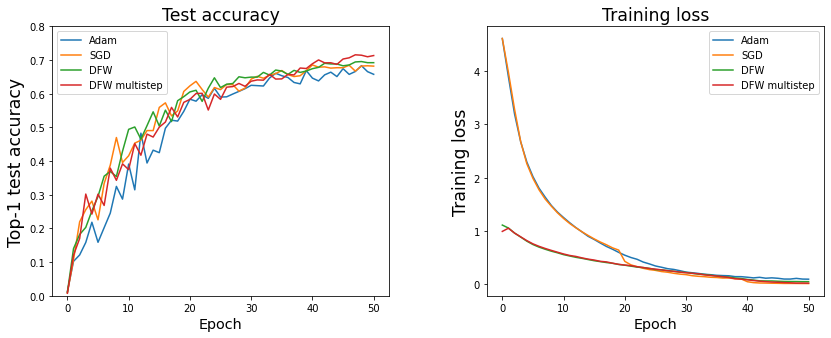

In [95]:
plot_stats(dataset_name, model_type)

In [157]:
output_folder = os.path.join(os.getcwd(), 'results/' + dataset_name + '/' + model_type)
os.makedirs(output_folder, exist_ok=True)
fname = output_folder + '/stats_dict_DFW.pkl'
with open(fname, 'rb') as handle:
    stats_dict = pickle.load(handle)
stats_dict

UnpicklingError: invalid load key, 'E'.

# Parameters used in the report

In order to reproduce our results, the following set of parameters should be used.\
If not specified, the remaining parameters (e.g. $\epsilon$ for Adam and Adagrad) are set to their default values.

Deep Frank Wolfe:\
$η = 0.1$, $μ = 0.9$, $w_d = 0$

Stochastic Gradient Descent:\
$\gamma = 0.001$, $\mu = 0.9$, $w_d = 0$

Adam:\
$\gamma = 0.001$, $\mu = 0.9$, $\beta_1 = 0.9$, $\beta_2 = 0.99$

AdaGrad:\
$\gamma = 0.001$, $w_d = 0$
